## Import

In [1]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split, GridSearchCV, LearningCurveDisplay, ShuffleSplit
from sklearn.metrics import f1_score, classification_report, recall_score, accuracy_score



# Variables

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

## Data Load

In [7]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

# Create Train&Test sets of data

In [9]:
train_x = train_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Class', 'Y_Quality'])
train_y = train_df[['Y_Class']]

test_x = test_df.drop(columns=['PRODUCT_ID', 'TIMESTAMP'])



In [10]:
train_x.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,349.000000,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.000000,349.000000,349.0,...,100.000000,100.00000,100.000000,100.000000,100.00000,99.0,0.0,0.0,0.0,0.0
mean,2.409742,95.123209,0.0,45.0,10.392550,0.0,48.802292,10.048711,41.469914,2.0,...,50.807300,53.60770,49.606200,51.659800,66.64970,1.0,NaN,NaN,NaN,NaN
std,5.895256,4.107640,0.0,0.0,0.489019,0.0,4.373824,0.215571,10.515032,0.0,...,7.011828,8.13899,7.158917,8.913065,4.52781,0.0,NaN,NaN,NaN,NaN
min,1.000000,87.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,32.120000,31.70000,32.560000,30.490000,61.67000,1.0,NaN,NaN,NaN,NaN
25%,2.000000,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,49.485000,52.20000,42.160000,49.915000,63.64500,1.0,NaN,NaN,NaN,NaN
50%,2.000000,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.000000,31.000000,2.0,...,53.425000,55.92500,51.460000,56.175000,65.14000,1.0,NaN,NaN,NaN,NaN
75%,2.000000,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.000000,52.000000,2.0,...,55.287500,58.97500,55.030000,57.175000,67.11500,1.0,NaN,NaN,NaN,NaN
max,103.000000,102.000000,0.0,45.0,11.000000,0.0,62.000000,11.000000,52.000000,2.0,...,60.240000,68.66000,60.410000,59.930000,79.75000,1.0,NaN,NaN,NaN,NaN


In [5]:
train_y.value_counts()

Y_Class
1          407
2          103
0           88
dtype: int64

## Data Pre-processing

In [6]:
all_nan_columns = train_x.loc[:,(train_x.isna() == True ).all(axis=0)].columns
# train_x = train_x -train_x.loc[:,(train_x.isna() == True ).all(axis=0)]
train_x = train_x.drop(columns=all_nan_columns )
test_x = test_x.drop(columns=all_nan_columns)
test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,183.8,467.0,444.192308,423.0,NaN,NaN,NaN,NaN,NaN,NaN
4,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,179.7,465.0,443.211539,423.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Look For Outliers

In [14]:
train_x.groupby('PRODUCT_CODE').count()

,LINE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
PRODUCT_CODE,,,,,,,,,,,,,,,,,,,,,
A_31,249,0,0,0,0,0,0,0,0,0,...,100,100,100,100,100,99,0,0,0,0
O_31,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
T_31,343,343,343,343,343,343,343,343,343,343,...,0,0,0,0,0,0,0,0,0,0


In [11]:
down_quantles = train_x.quantile(0.2, numeric_only=True)
up_quantles = train_x.quantile(0.8, numeric_only=True)

train_x = train_x.mask( train_x > up_quantles, up_quantles, axis=1)
train_x = train_x.mask( train_x < down_quantles, down_quantles, axis=1)




C:\Users\pshn1\AppData\Local\Temp\ipykernel_22976\4065293770.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train_x = train_x.mask( train_x > up_quantles, up_quantles, axis=1)
C:\Users\pshn1\AppData\Local\Temp\ipykernel_22976\4065293770.py:5: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  train_x = train_x.mask( train_x < down_quantles, down_quantles, axis=1)


LINE            T100306
PRODUCT_CODE       T_31
X_1                 2.0
X_2               100.0
X_3                 0.0
                 ...   
X_2871              1.0
X_2872              NaN
X_2873              NaN
X_2874              NaN
X_2875              NaN
Length: 2877, dtype: object

In [12]:
train_x.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
count,349.0,349.000000,349.0,349.0,349.000000,349.0,349.000000,349.0,349.000000,349.0,...,100.000000,100.000000,100.000000,100.000000,100.000000,99.0,0.0,0.0,0.0,0.0
mean,2.0,95.263610,0.0,45.0,10.392550,0.0,48.272206,10.0,41.469914,2.0,...,52.239800,55.440500,49.483800,54.091500,65.421800,1.0,NaN,NaN,NaN,NaN
std,0.0,3.242918,0.0,0.0,0.489019,0.0,3.414447,0.0,10.515032,0.0,...,3.475202,3.258853,5.963321,3.750334,1.809294,0.0,NaN,NaN,NaN,NaN
min,2.0,91.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,31.000000,2.0,...,46.560000,50.932000,41.058000,47.996000,63.176000,1.0,NaN,NaN,NaN,NaN
25%,2.0,93.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,31.000000,2.0,...,49.485000,52.200000,42.160000,49.915000,63.645000,1.0,NaN,NaN,NaN,NaN
50%,2.0,95.000000,0.0,45.0,10.000000,0.0,45.000000,10.0,31.000000,2.0,...,53.425000,55.925000,51.460000,56.175000,65.140000,1.0,NaN,NaN,NaN,NaN
75%,2.0,98.000000,0.0,45.0,11.000000,0.0,51.000000,10.0,52.000000,2.0,...,55.287500,58.975000,55.030000,57.175000,67.115000,1.0,NaN,NaN,NaN,NaN
max,2.0,100.000000,0.0,45.0,11.000000,0.0,53.000000,10.0,52.000000,2.0,...,55.708000,59.378000,55.770000,57.340000,67.984000,1.0,NaN,NaN,NaN,NaN


In [7]:
train_x_mean = train_x.fillna(train_x.mean())
test_x_mean = test_x.fillna(train_x.mean())

train_x_median = train_x.fillna(train_x.median())
test_x_median = test_x.fillna(train_x.median())

train_x_zero = train_x.fillna(0)
test_x_zero = test_x.fillna(0)

test_x_median

C:\Users\pshn1\AppData\Local\Temp\ipykernel_24524\1816340917.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train_x_mean = train_x.fillna(train_x.mean())
C:\Users\pshn1\AppData\Local\Temp\ipykernel_24524\1816340917.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_x_mean = test_x.fillna(train_x.mean())
C:\Users\pshn1\AppData\Local\Temp\ipykernel_24524\1816340917.py:4: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifyin

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0
3,T010305,A_31,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,183.8,467.0,444.192308,423.0,53.425,55.925,51.46,56.175,65.14,1.0
4,T010306,A_31,2.0,95.0,0.0,45.0,10.0,0.0,45.0,10.0,...,179.7,465.0,443.211539,423.0,53.425,55.925,51.46,56.175,65.14,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,163.3,446.0,427.867925,406.0,53.425,55.925,51.46,56.175,65.14,1.0


In [8]:
test_x_mean.isna().values.any()

False

# Model Fit Variables

In [14]:
MODEL_TEST_REPEAT=5
TRAINING_DATA=train_x.fillna(0)
TESTING_DATA=test_x.fillna(0)

# Label Encoding

In [15]:
# qualitative to quantitative
qual_col = ['PRODUCT_CODE','LINE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(TRAINING_DATA[i])
    TRAINING_DATA[i] = le.transform(TRAINING_DATA[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    TESTING_DATA[i] = le.transform(TESTING_DATA[i]) 
print('Done.')

Done.


# Checking if imbalanced

In [11]:
print(f"yclass 0 in tarin_df : {train_df[train_df['Y_Class']==0].shape[0]}")
print(f"yclass 1 in tarin_df : {train_df[train_df['Y_Class']==1].shape[0]}")
print(f"yclass 2 in tarin_df : {train_df[train_df['Y_Class']==2].shape[0]}")

yclass 0 in tarin_df : 88
yclass 1 in tarin_df : 407
yclass 2 in tarin_df : 103


In [16]:
from sklearn.neighbors import KNeighborsClassifier as KNN
KNN_model = KNN(n_neighbors=11)
KNN_model.fit(TRAINING_DATA, train_y)
pred_knn = KNN_model.predict(TRAINING_DATA)
# print(recall_score(train_y, pred_knn))
# print(accuracy_score(train_y, pred_knn))
print(classification_report(train_y, pred_knn))

d:\Dev_ggu_Ddrive\venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.54      0.38      0.44        88
           1       0.78      0.93      0.85       407
           2       0.62      0.32      0.42       103

    accuracy                           0.74       598
   macro avg       0.65      0.54      0.57       598
weighted avg       0.72      0.74      0.72       598



# Data OverSampling by imblearn

In [17]:
from imblearn.over_sampling import SMOTE

oversampling_instance = SMOTE(k_neighbors=3)

o_Train_X, o_Train_Y = oversampling_instance.fit_resample(TRAINING_DATA, train_y)

o_Train_X = pd.DataFrame(o_Train_X, columns=o_Train_X.columns)
# o_Train_Y = pd.Series(o_Train_Y)

o_Train_Y.value_counts()

Y_Class
0          407
1          407
2          407
dtype: int64

In [ ]:
# d = {
#     'columns': train_x_del_zeros.columns.values,
#     'importances': RF.feature_importances_,
# }

# temp_df = pd.DataFrame(d)
# temp_df = temp_df[temp_df['importances'] != 0]
# temp_df.sort_values(by='importances', ascending=False)
# temp_df[temp_df['importances'] > 1/1704]['columns'].values

In [ ]:
# import plotly.express as px

# px.line(data_frame=temp_df,
#         x='columns',
#         y='importances')

# Resampling by imortances

In [ ]:
# train_x_v2 = train_df[temp_df[temp_df['importances'] > 1/1704]['columns'].values]
# train_x_v2 = train_x_v2.fillna(0)

# test_x_v2 = test_df[temp_df[temp_df['importances'] > 1/1704]['columns'].values]
# test_x_v2 = test_x_v2.fillna(0)


# Classifier Model Fit

# Gradient Boost Model Fit

In [ ]:
# target = train_df['Y_Class']

# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     GB = GradientBoostingClassifier(learning_rate = 0.05)
#     GB.fit(X_train_rand, y_train_rand)

#     preds = GB.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")



In [ ]:
# testing0oversampled dataset
# target = o_Train_Y['Y_Class']

# features = o_Train_X
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     GB = GradientBoostingClassifier(learning_rate = 0.05)
#     GB.fit(X_train_rand, y_train_rand)

#     preds = GB.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")


In [ ]:
# print(classification_report(y_test_rand, preds))

# Check if Overfitted

In [ ]:
# import matplotlib.pyplot as plt

# def learning_curve(history, epoch):
#   plt.figure(figsize = (10,5))
#   epoch_range = np.arange(1, epoch + 1)

#   plt.subplot(1, 2, 1)

#   plt.plot(epoch_range, history.history['accuracy'])
#   plt.plot(epoch_range, history.history['val_accuracy'])
#   plt.title('Model Accuracy')
#   plt.xlabel('epoch')
#   plt.ylabel('Accuracy')
#   plt.legend(['Train', 'Val'])

#   plt.subplot(1,2,2)

#   plt.plot(epoch_range, history.history['loss'])
#   plt.plot(epoch_range, history.history['val_loss'])
#   plt.title('Model loss')
#   plt.xlabel('epoch')
#   plt.ylabel('loss')
#   plt.legend(['Train', 'Val'])
#   plt.show()

# history = GB

# learning_curve(history, 50)

# GaussianNB Model Fit

In [ ]:
# target = train_df['Y_Class']

# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     clf = GaussianNB()
#     clf.fit(X_train_rand, y_train_rand)

#     preds = clf.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")



# RandomForest Classifier Model Fit

In [ ]:
# target = train_df['Y_Class']

# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     RF_rand = RandomForestClassifier()
#     RF_rand.fit(X_train_rand, y_train_rand)

#     preds = RF_rand.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")



# CatBoost Classifier Model Fit

In [ ]:
# target = train_df['Y_Class']


# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                                             target, 
#                                                                             test_size=0.2, 
#                                                                             )

#     catboost_clf = CatBoostClassifier(iterations=40,
#                            depth=2,
#                            learning_rate=0.02,
#                            loss_function='MultiClass',
#                            verbose=True)
    
#     catboost_clf.fit(X_train_rand, y_train_rand)

#     preds = catboost_clf.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))
    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")

In [ ]:
# print(classification_report(y_test_rand, preds))

In [ ]:
# grid_parameters = {'depth'         : [6,8,10],
#                     'learning_rate' : [0.01, 0.05, 0.1],
#                     'iterations'    : [30, 50, 100]
#                     }

# grid = GridSearchCV(estimator=catboost_clf, param_grid = grid_parameters, cv = 2, n_jobs=-1)
# grid.fit(X_train_rand, y_train_rand)

# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
# print("\n The best score across ALL searched params:\n", grid.best_score_)
# print("\n The best parameters across ALL searched params:\n", grid.best_params_)


# XGB Classifier Model Fit

In [ ]:
# import xgboost as xgb

# # XGBoost를 사용하기 위해서는 DMatrix 형태로 변환해 주어야 합니다
# dtrain = xgb.DMatrix(train_x, train_y)
# dtest = xgb.DMatrix(test_x)

# # 모델 생성
# # num_boost_round 만큼 반복하는데 early_stopping_rounds 만큼 성능 향상이 없으면 중단
# # early_stopping_rounds를 사용하려면 eval 데이터 셋을 명기해야함
# param = {파라미터 설정}
# xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = 400, 
#                         early_stopping_rounds = 100, evals=[(dtrain,'train'),(dval,'eval')])

# # 예측하기, 확률값으로 반환됨
# y_pre_probs = xgb_model.predict(dtest)

# # 0또는 1로 변경
# y_preds = [1 if x>0.5 else 0 for x in y_pre_probs]

# Voting Classifier Model Fit -> Merging Multiple Models

In [ ]:
# target = train_df['Y_Class']
# features = TRAINING_DATA
# scores=[]
# for i in range(MODEL_TEST_REPEAT):
#     X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
#                                                         target, 
#                                                         test_size=0.2, 
#                                                         )

#     Voting_Clf = VotingClassifier(estimators=[ 
#                                               ('RandomForest', RF_rand) ,
#                                               ('GaussianNB', clf),
#                                                 ('CatBoostClassifier', catboost_clf)],
#                                   voting='soft')
    
#     Voting_Clf.fit(X_train_rand, y_train_rand)
    
    
#     preds = Voting_Clf.predict(X_test_rand)
#     scores.append(f1_score(y_test_rand, preds,average='macro'))

    
# print(f"평균: {np.average(scores)}")
# print(f"최소: {min(scores)}")
# print(f"최대: {max(scores)}")

In [ ]:
# vot_esti = []
# for i in range(10):
#     globals()["gb_test_".format(i)] = GradientBoostingClassifier(  n_estimators = 150 ,
#                                                                     learning_rate = 0.05 ,
#                                                                      verbose = 2
#                                                                     )
#     # globals()["gb_test_".format(i)].fit(o_Train_X, o_Train_Y['Y_Class'])
#     vot_esti.append((f"gb_{i}", globals()["gb_test_".format(i)]))
    



In [ ]:
# # voting with 10 gbs
# voting_clf_10gb = VotingClassifier(estimators=vot_esti,
#                                   voting='soft')

# voting_clf_10gb.fit(o_Train_X, o_Train_Y['Y_Class'])

# preds = voting_clf_10gb.predict(TESTING_DATA)

      Iter       Train Loss   Remaining Time 
         1           1.0539            2.57m
         2           1.0139            2.56m
         3           0.9771            2.57m
         4           0.9433            2.62m
         5           0.9131            2.71m
         6           0.8851            2.76m
         7           0.8570            2.70m
         8           0.8301            2.64m
         9           0.8046            2.58m
        10           0.7815            2.54m
        11           0.7597            2.49m
        12           0.7385            2.46m
        13           0.7191            2.42m
        14           0.7013            2.39m
        15           0.6826            2.36m
        16           0.6669            2.34m
        17           0.6512            2.31m
        18           0.6361            2.29m
        19           0.6213            2.27m
        20           0.6077            2.24m
        21           0.5953            2.22m
        2

In [ ]:
# print(classification_report(o_Train_Y['Y_Class'], preds))

In [ ]:
# preds = GB.predict(TESTING_DATA)

# F1_Score

In [ ]:
# f1_temp = train_y['Y_Class'].values
# f1_temp[f1_temp==2]=0
# f1_temp

In [ ]:
# f1_score(f1_temp, preds)

In [30]:
target = train_y['Y_Class']
features = train_x.fillna(0)


X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4, 
                                                                            random_state=445
                                                                            )

plt_testing_gb =  GradientBoostingClassifier(  n_estimators = 150 ,
                                                learning_rate = 0.05 ,
                                                    verbose = 2,
                                                    max_depth=2
                                                )

plt_testing_gb.fit(X_train_rand,y_train_rand)

train_temp = plt_testing_gb.predict(X_train_rand)
test_temp = plt_testing_gb.predict(X_test_rand)


print(f'testscore{f1_score(y_test_rand, test_temp,average="macro")} trainscore{f1_score(y_train_rand, train_temp,average="macro")}')

      Iter       Train Loss   Remaining Time 
         1           0.8100           22.37s
         2           0.7854           23.43s
         3           0.7655           24.17s
         4           0.7482           23.25s
         5           0.7326           22.69s
         6           0.7158           22.25s
         7           0.7032           22.24s
         8           0.6901           22.17s
         9           0.6765           21.74s
        10           0.6655           21.52s
        11           0.6556           21.22s
        12           0.6458           21.01s
        13           0.6352           20.78s
        14           0.6267           20.64s
        15           0.6183           20.38s
        16           0.6102           20.16s
        17           0.6028           19.96s
        18           0.5945           19.92s
        19           0.5871           19.66s
        20           0.5807           19.47s
        21           0.5740           19.26s
        2

In [21]:
d = {
    'columns': test_x.columns.values,
    'importances': plt_testing_gb.feature_importances_,
}

temp_df = pd.DataFrame(d)
temp_df = temp_df[temp_df['importances'] != 0]
temp_df.sort_values(by='importances', ascending=False)
temp_df[temp_df['importances'] > 0.004]['columns'].values

array(['X_73', 'X_103', 'X_107', 'X_120', 'X_121', 'X_248', 'X_257',
       'X_367', 'X_368', 'X_380', 'X_399', 'X_462', 'X_524', 'X_525',
       'X_531', 'X_533', 'X_554', 'X_608', 'X_709', 'X_717', 'X_718',
       'X_720', 'X_757', 'X_786', 'X_853', 'X_855', 'X_863', 'X_894',
       'X_899', 'X_932', 'X_979', 'X_985', 'X_1044', 'X_1060', 'X_1179',
       'X_1212', 'X_1291', 'X_1329', 'X_1333', 'X_1343', 'X_1437',
       'X_1560', 'X_1601', 'X_1743', 'X_1770', 'X_1849', 'X_1954',
       'X_2063', 'X_2070', 'X_2079', 'X_2086', 'X_2106', 'X_2455',
       'X_2467', 'X_2552', 'X_2700', 'X_2722'], dtype=object)

In [22]:
import plotly.express as px

px.line(data_frame=temp_df,
        x='columns',
        y='importances')

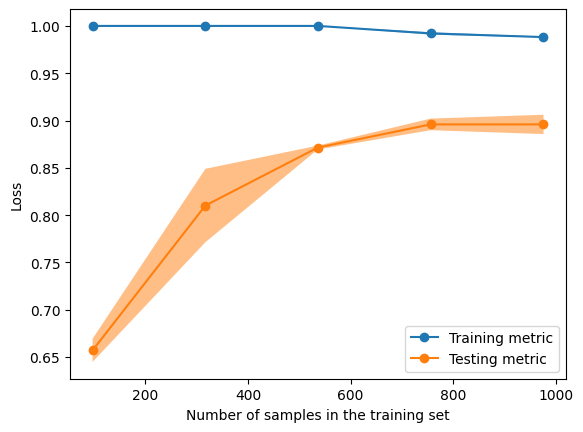

In [19]:
import matplotlib.pyplot as plt

common_params = {
    "X": o_Train_X,
    "y": o_Train_Y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=2, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(plt_testing_gb, **common_params)

plt.show()

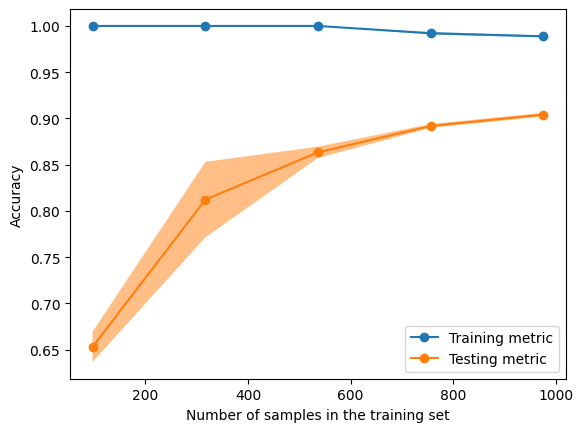

In [18]:
import matplotlib.pyplot as plt

common_params = {
    "X": o_Train_X,
    "y": o_Train_Y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=2, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

LearningCurveDisplay.from_estimator(plt_testing_gb, **common_params)

plt.show()

## Submit

In [33]:
submit = pd.read_csv('./sample_submission.csv')

In [34]:
submit['Y_Class'] = preds

In [58]:
submit.groupby(['Y_Class']).count()

,PRODUCT_ID
Y_Class,
0,58
1,224
2,28


In [36]:
submit.to_csv('./baseline_submission.csv', index=False)